### Imports

In [1]:
#Imports utilizados nesse case
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#Importamos nosso dataset usando encondig de ISO-8859-1 pra evitar erros com UTF-8
df = pd.read_csv("alipaga_dataset.csv", encoding = "ISO-8859-1")

In [3]:
#Exibimos um pedaço do dataset, ainda sem modificações
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,...,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
2,48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,...,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High
3,11731,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,...,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High
4,22255,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium


In [4]:
#Descrição geral dos valores do dataset
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.00000,9994.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,55190.379428,246.490581,3.476545,0.142908,28.610982,26.375915
std,14806.29199,32063.693350,487.565361,2.278766,0.212280,174.340972,57.296804
min,1.00000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,12823.25000,23223.000000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,56430.500000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,90008.000000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,99301.000000,22638.480000,14.000000,0.850000,8399.976000,933.570000


### Pré-processamento

In [5]:
print("Quantidade de Colunas: ",len(df.columns))

Quantidade de Colunas:  24


In [6]:
#Todas as Colunas
print(*df.columns) 

Row ID Order ID Order Date Ship Date Ship Mode Customer ID Customer Name Segment City State Country Postal Code Market Region Product ID Category Sub-Category Product Name Sales Quantity Discount Profit Shipping Cost Order Priority


In [7]:
#Tratamos as colunas, mudando seus nomes para lowe e substituindo espaço por _
df.rename(columns = lambda x: x.lower().replace(' ', '_').replace('-', '_'), inplace=True)

In [8]:
#Colunas após as modificações
print(*df.columns) 

row_id order_id order_date ship_date ship_mode customer_id customer_name segment city state country postal_code market region product_id category sub_category product_name sales quantity discount profit shipping_cost order_priority


In [9]:
#Checa se há alguma coluna com missing data
df.isna().any().any()

True

In [10]:
#Encontra a coluna que possui missing data
df.loc[:, df.isnull().any()].columns

Index(['postal_code'], dtype='object')

In [11]:
#Drop no postal_code, coluna contendo missing data e que não usaremos nesse caso
df = df.drop(columns=["postal_code"])

In [12]:
#Transforma o estilo de datas do dataset no padrão YYYY-MM-DD
df['order_date'] = pd.to_datetime(df.order_date)

In [13]:
#Transforma a order_priority mapeando seus valores para números
al_ = np.unique(df["order_priority"])
prior ={'Critical':3, 'High':2, 'Medium':1, 'Low': 0}
df["order_priority"] = df["order_priority"].apply(lambda x: prior[x])

In [14]:
df["order_priority"].head()

0    1
1    1
2    2
3    2
4    1
Name: order_priority, dtype: int64

In [30]:
#Junta os valores diários de vendas em um novo dataframe
sales_day = df.groupby(["order_date"]).sales.sum().reset_index()

#Junta a quantidade diária de vendas em um novo dataframe
qt_day = df.groupby(["order_date"]).quantity.sum().reset_index()

#Agrupa esses valores diários em valores mensais
sales_month = sales_day.groupby(pd.Grouper(key='order_date', freq='M')).sum().reset_index()
qt_month = qt_day.groupby(pd.Grouper(key='order_date', freq='M')).sum().reset_index()

In [31]:
#Mostra o agrupamento diário
sales_day.head(5)

,order_date,sales
0,2011-01-01,808.5630
1,2011-01-02,2455.6700
2,2011-01-03,12565.7663
3,2011-01-04,2582.8010
4,2011-01-06,11480.4927


In [32]:
#Mostra o agrupamento mensal
sales_month.head(5)

,order_date,sales
0,2011-01-31,138241.30042
1,2011-02-28,134969.94086
2,2011-03-31,171455.59372
3,2011-04-30,128833.47034
4,2011-05-31,148146.72092


In [33]:
#Remove os "dias" da order_date de sales_month
sales_month["order_date"] = sales_month['order_date'].apply(lambda x: x.strftime('%Y-%m'))

In [34]:
#Remove os "dias" da order_date de qt_month
qt_month["order_date"] = qt_month['order_date'].apply(lambda x: x.strftime('%Y-%m'))

In [19]:
#Mostra o agrupamento mensal
sales_month.head(5)

,order_date,sales
0,2011-01,138241.30042
1,2011-02,134969.94086
2,2011-03,171455.59372
3,2011-04,128833.47034
4,2011-05,148146.72092


### Total de Vendas por Mês/Ano

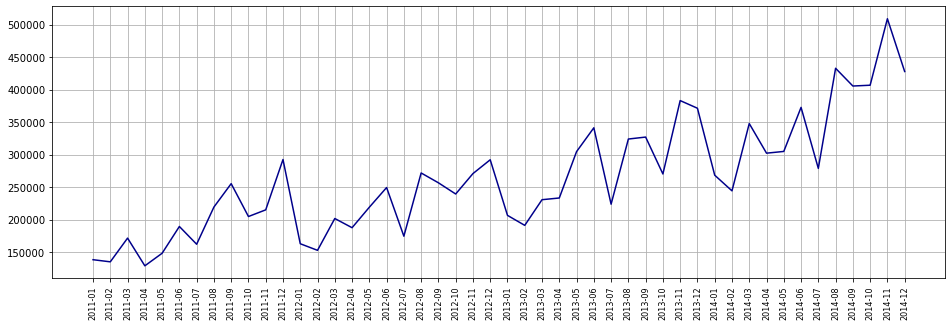

In [39]:
#Plotamos os valores de venda de acordo com os meses dos anos entre 2011-2014
plt.figure(figsize=(16, 5))
plt.plot(sales_month['order_date'], sales_month['sales'], color='darkblue')
plt.xticks(rotation='vertical', size=8)
plt.grid()
plt.show()

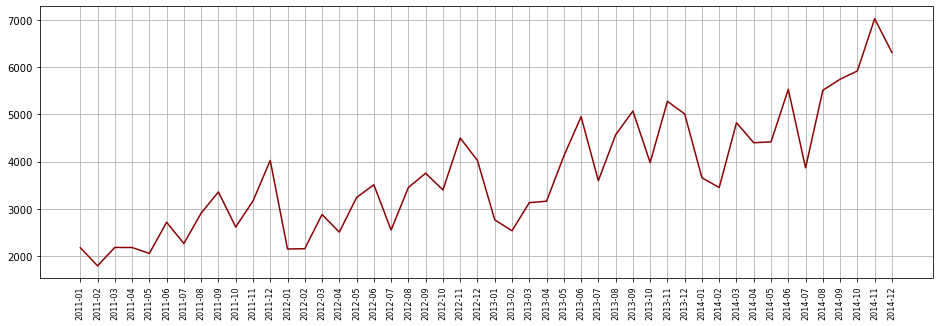

In [59]:
#Plotamos os valores de venda de acordo com os meses dos anos entre 2011-2014
plt.figure(figsize=(16, 5))
plt.plot(qt_month['order_date'], qt_month['quantity'], color='darkred')
plt.xticks(rotation='vertical', size=8)
plt.grid()
plt.show()

### Produtos que arrecadaram mais valor

In [61]:
#Separamos uma parte do dataframe que contem os produtos/total de vendas
prod_ = df.groupby('product_name').sum()['sales'].to_frame()
prod_.sort_values(by=['sales'], inplace=True, ascending=False)
prod_[:10]

,sales
product_name,
"Apple Smart Phone, Full Size",86935.7786
"Cisco Smart Phone, Full Size",76441.5306
"Motorola Smart Phone, Full Size",73156.3030
"Nokia Smart Phone, Full Size",71904.5555
Canon imageCLASS 2200 Advanced Copier,61599.8240
"Hon Executive Leather Armchair, Adjustable",58193.4841
"Office Star Executive Leather Armchair, Adjustable",50661.6840
"Harbour Creations Executive Leather Armchair, Adjustable",50121.5160
"Samsung Smart Phone, Cordless",48653.4600


In [62]:
print("Principais produtos vendidos:\n", prod_.head(10))

Principais produtos vendidos:
                                                          sales
product_name                                                  
Apple Smart Phone, Full Size                        86935.7786
Cisco Smart Phone, Full Size                        76441.5306
Motorola Smart Phone, Full Size                     73156.3030
Nokia Smart Phone, Full Size                        71904.5555
Canon imageCLASS 2200 Advanced Copier               61599.8240
Hon Executive Leather Armchair, Adjustable          58193.4841
Office Star Executive Leather Armchair, Adjustable  50661.6840
Harbour Creations Executive Leather Armchair, A...  50121.5160
Samsung Smart Phone, Cordless                       48653.4600
Nokia Smart Phone, with Caller ID                   47877.7857


In [63]:
#Agrupa os produtos que mais venderam (em quantidade)
prod_q = df.groupby('product_name').sum()['quantity'].to_frame()
prod_q.sort_values(by=['quantity'], inplace=True, ascending=False)
prod_q[:10]

,quantity
product_name,
Staples,876
"Cardinal Index Tab, Clear",337
"Eldon File Cart, Single Width",321
"Rogers File Cart, Single Width",262
"Sanford Pencil Sharpener, Water Color",259
"Stockwell Paper Clips, Assorted Sizes",253
"Avery Index Tab, Clear",252
"Ibico Index Tab, Clear",251
"Smead File Cart, Single Width",250


### Quantos dos clientes utilizaram descontos?

In [65]:
#Captura os valores maiores que 0
f_t = (df['discount'] > 0).value_counts()

In [66]:
max = f_t[0] + f_t[1]

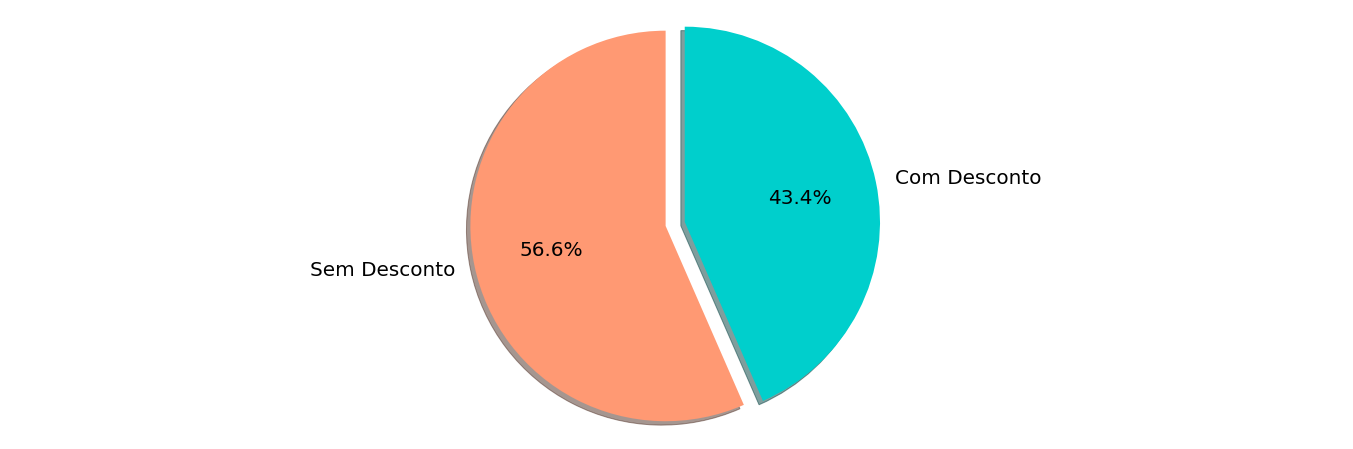

In [71]:
#Definição do gráfico de torta 
labels = 'Sem Desconto', 'Com Desconto'
sizes = [f_t[0]/100 , f_t[1]/100]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ["#ff9973","#00cfcc"]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors=colors, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 20})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Quais foram os produtos que mais obtiveram descontos

In [72]:
discount = df.groupby(df["product_name"]).discount.sum().reset_index()
discount.sort_values(by=['discount'], inplace=True, ascending=False)
discount.head(10)

,product_name,discount
3275,Staples,21.20
2840,"Rogers File Cart, Single Width",16.26
3179,"Smead File Cart, Single Width",13.06
3194,"Smead Lockers, Single Width",11.21
3354,"Stockwell Thumb Tacks, Metal",10.75
1981,"Ibico Index Tab, Clear",10.71
3070,"Sanford Pencil Sharpener, Water Color",10.66
894,"Cardinal Index Tab, Clear",10.32
3335,"Stockwell Paper Clips, Assorted Sizes",9.86
3400,"Tenex File Cart, Single Width",9.71


### Métodos de envio preferidos


In [73]:
df["ship_mode"].value_counts()

Standard Class    30775
Second Class      10309
First Class        7505
Same Day           2701
Name: ship_mode, dtype: int64

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


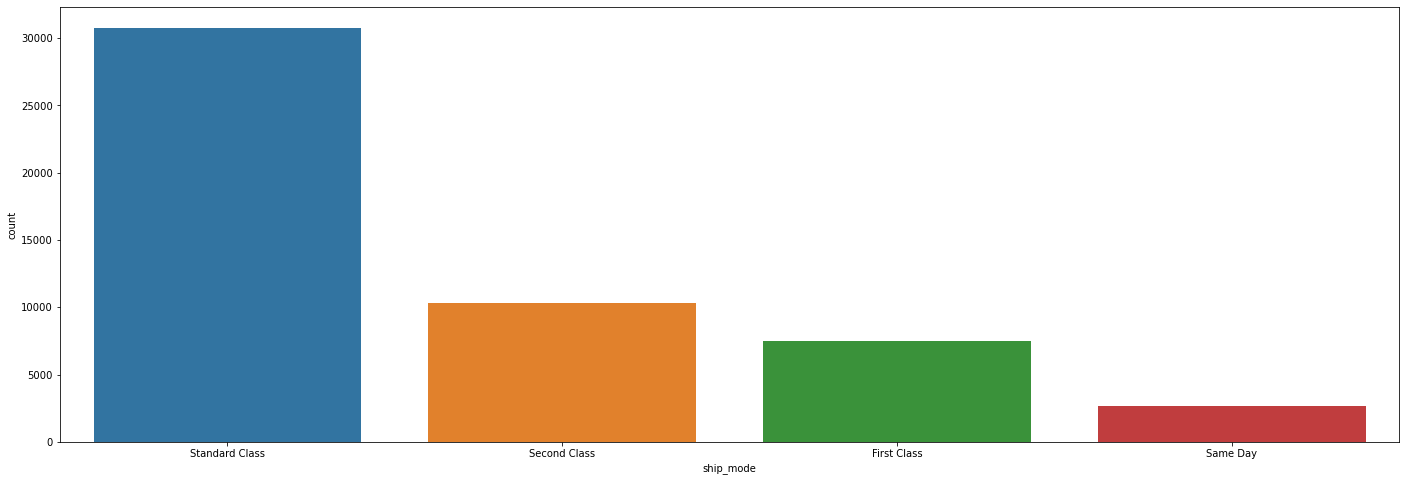

In [74]:
sns.countplot(df["ship_mode"])

### Questão pautada no Case - Impacto de Shipping Cost e Discount

In [75]:
df.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'city', 'state', 'country',
       'market', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit',
       'shipping_cost', 'order_priority'],
      dtype='object')

Primeiro calcularemos a correlação entre as duas colunas desejadas:

In [80]:
corr_ = df['shipping_cost'].corr(df['discount'])

In [81]:
print(corr_)

-0.07905555107216274


Apontamos as correlações de todas as colunas entre si, notamos que há uma certa correlação entre o shipping cost e sales

In [83]:
corr_geral = df.corr().drop(columns=["row_id"])
corr_geral

,sales,quantity,discount,profit,shipping_cost,order_priority
row_id,-0.043889,-0.173483,0.087594,-0.019037,-0.039078,0.013542
sales,1.000000,0.313577,-0.086722,0.484918,0.768073,0.002883
quantity,0.313577,1.000000,-0.019875,0.104365,0.272649,-0.002450
discount,-0.086722,-0.019875,1.000000,-0.316490,-0.079056,-0.005492
profit,0.484918,0.104365,-0.316490,1.000000,0.354441,0.001762
shipping_cost,0.768073,0.272649,-0.079056,0.354441,1.000000,0.175700
order_priority,0.002883,-0.002450,-0.005492,0.001762,0.175700,1.000000


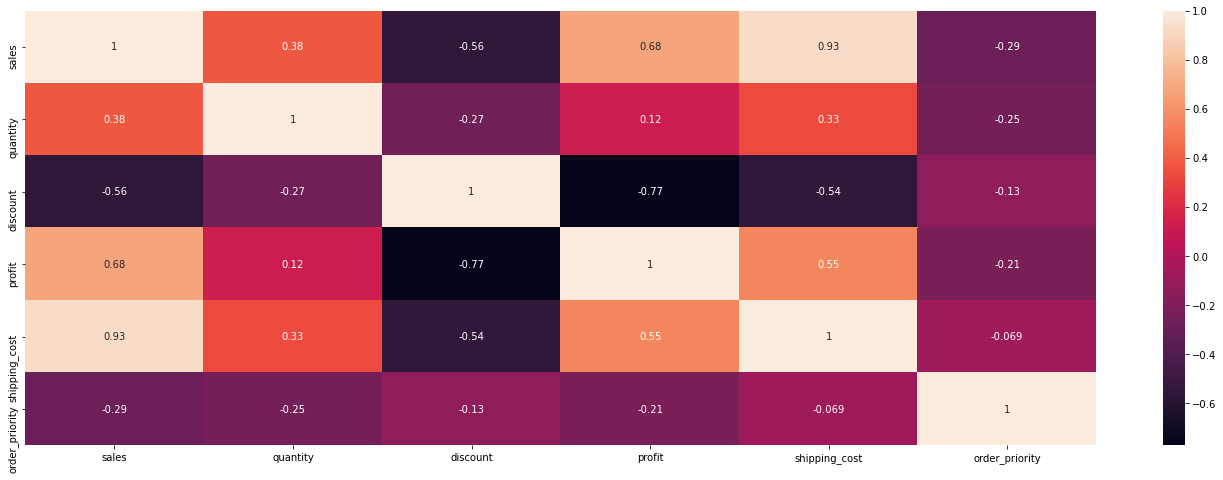

In [84]:
sns.heatmap(corr_geral.corr(), annot=True)

In [85]:
sales_ship = df['sales'].corr(df['shipping_cost'])
sales_qt = df['quantity'].corr(df['shipping_cost'])
print("Correlação entre valor de vendas e custo de envio: ", sales_ship)
print("Correlação entre quantidade de vendas e custo de envio: ", sales_qt)

Correlação entre valor de vendas e custo de envio:  0.7680728376889517
Correlação entre quantidade de vendas e custo de envio:  0.2726489733767308


In [86]:
columns = df[["order_date","row_id","sales","quantity","country","profit"]]
df_sales = columns.copy()

In [87]:
df_sales

,order_date,row_id,sales,quantity,country,profit
0,2011-01-01,42433,408.300,2,Algeria,106.1400
1,2011-01-01,22253,120.366,3,Australia,36.0360
2,2011-01-01,48883,66.120,4,Hungary,29.6400
3,2011-01-01,11731,44.865,3,Sweden,-26.0550
4,2011-01-01,22255,113.670,5,Australia,37.7700
...,...,...,...,...,...,...
51285,2014-12-31,32593,13.904,2,United States,4.5188
51286,2014-12-31,47594,3.990,1,Morocco,0.4200
51287,2014-12-31,8857,26.400,3,Nicaragua,12.3600
51288,2014-12-31,6852,7.120,1,Mexico,0.5600


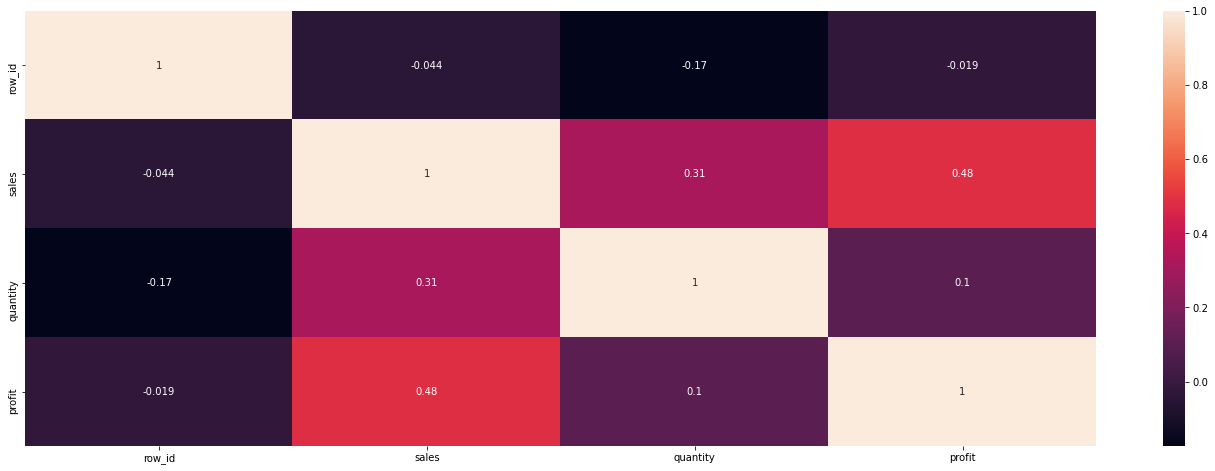

In [88]:
sns.heatmap(df_sales.corr(), annot=True)

In [89]:
n_paises = len(np.unique(df_sales["country"]))

In [90]:
dff = df_sales.groupby(["country"]).sales.sum().reset_index()
dff.sort_values(by=["sales"], ascending=False)

,country,sales
139,United States,2.297201e+06
6,Australia,9.252359e+05
44,France,8.589311e+05
26,China,7.005620e+05
47,Germany,6.288400e+05
...,...,...
127,Tajikistan,2.427840e+02
75,Macedonia,2.096400e+02
40,Eritrea,1.877400e+02
5,Armenia,1.567500e+02


In [91]:
dff_q = df_sales.groupby(["country"]).quantity.sum().reset_index()
dff_q = dff_q.sort_values(by=["quantity"], ascending=False)
dff_q

,country,quantity
139,United States,37873
44,France,10804
6,Australia,10673
81,Mexico,10011
47,Germany,7745
...,...,...
118,South Sudan,5
40,Eritrea,4
19,Burundi,4
5,Armenia,3


In [92]:
import matplotlib.style as style
dims = (30, 20)
##len(df["country"].unique())

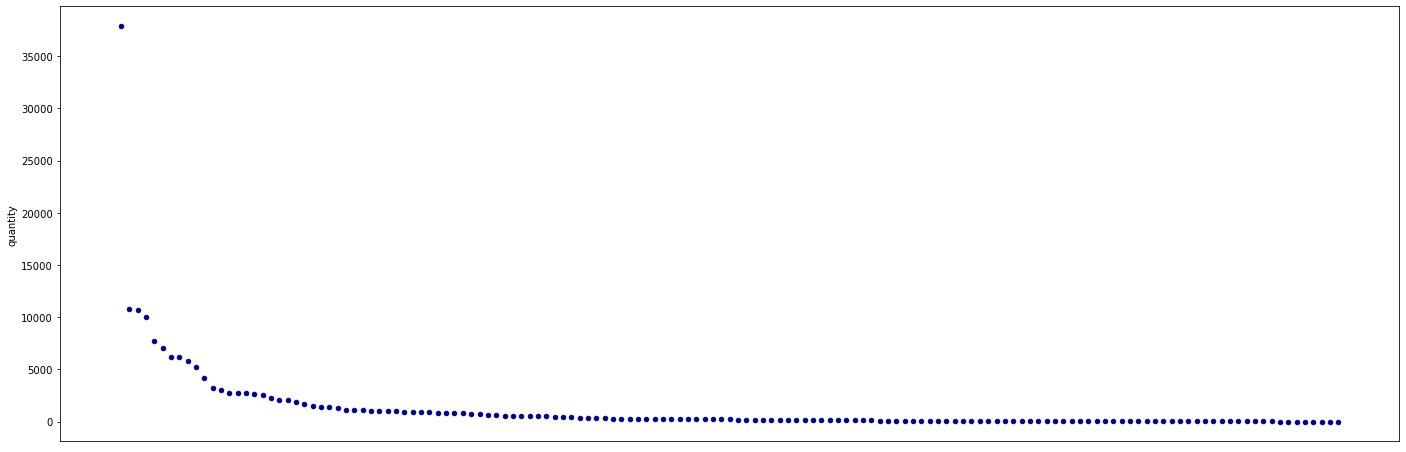

In [93]:
ax1 = dff_q.plot.scatter(x='country',
                      y='quantity',
                      c='DarkBlue')
ax1.get_xaxis().set_visible(False)

In [94]:
import numpy as np
import pandas as pd
outliers=[]
def detect_outlier(data_1):
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [95]:
outlier_datapoints = detect_outlier(dff_q["quantity"])
print(outlier_datapoints[0])
print(dff_q[dff_q["quantity"] == outlier_datapoints[0]])

37873
           country  quantity
139  United States     37873


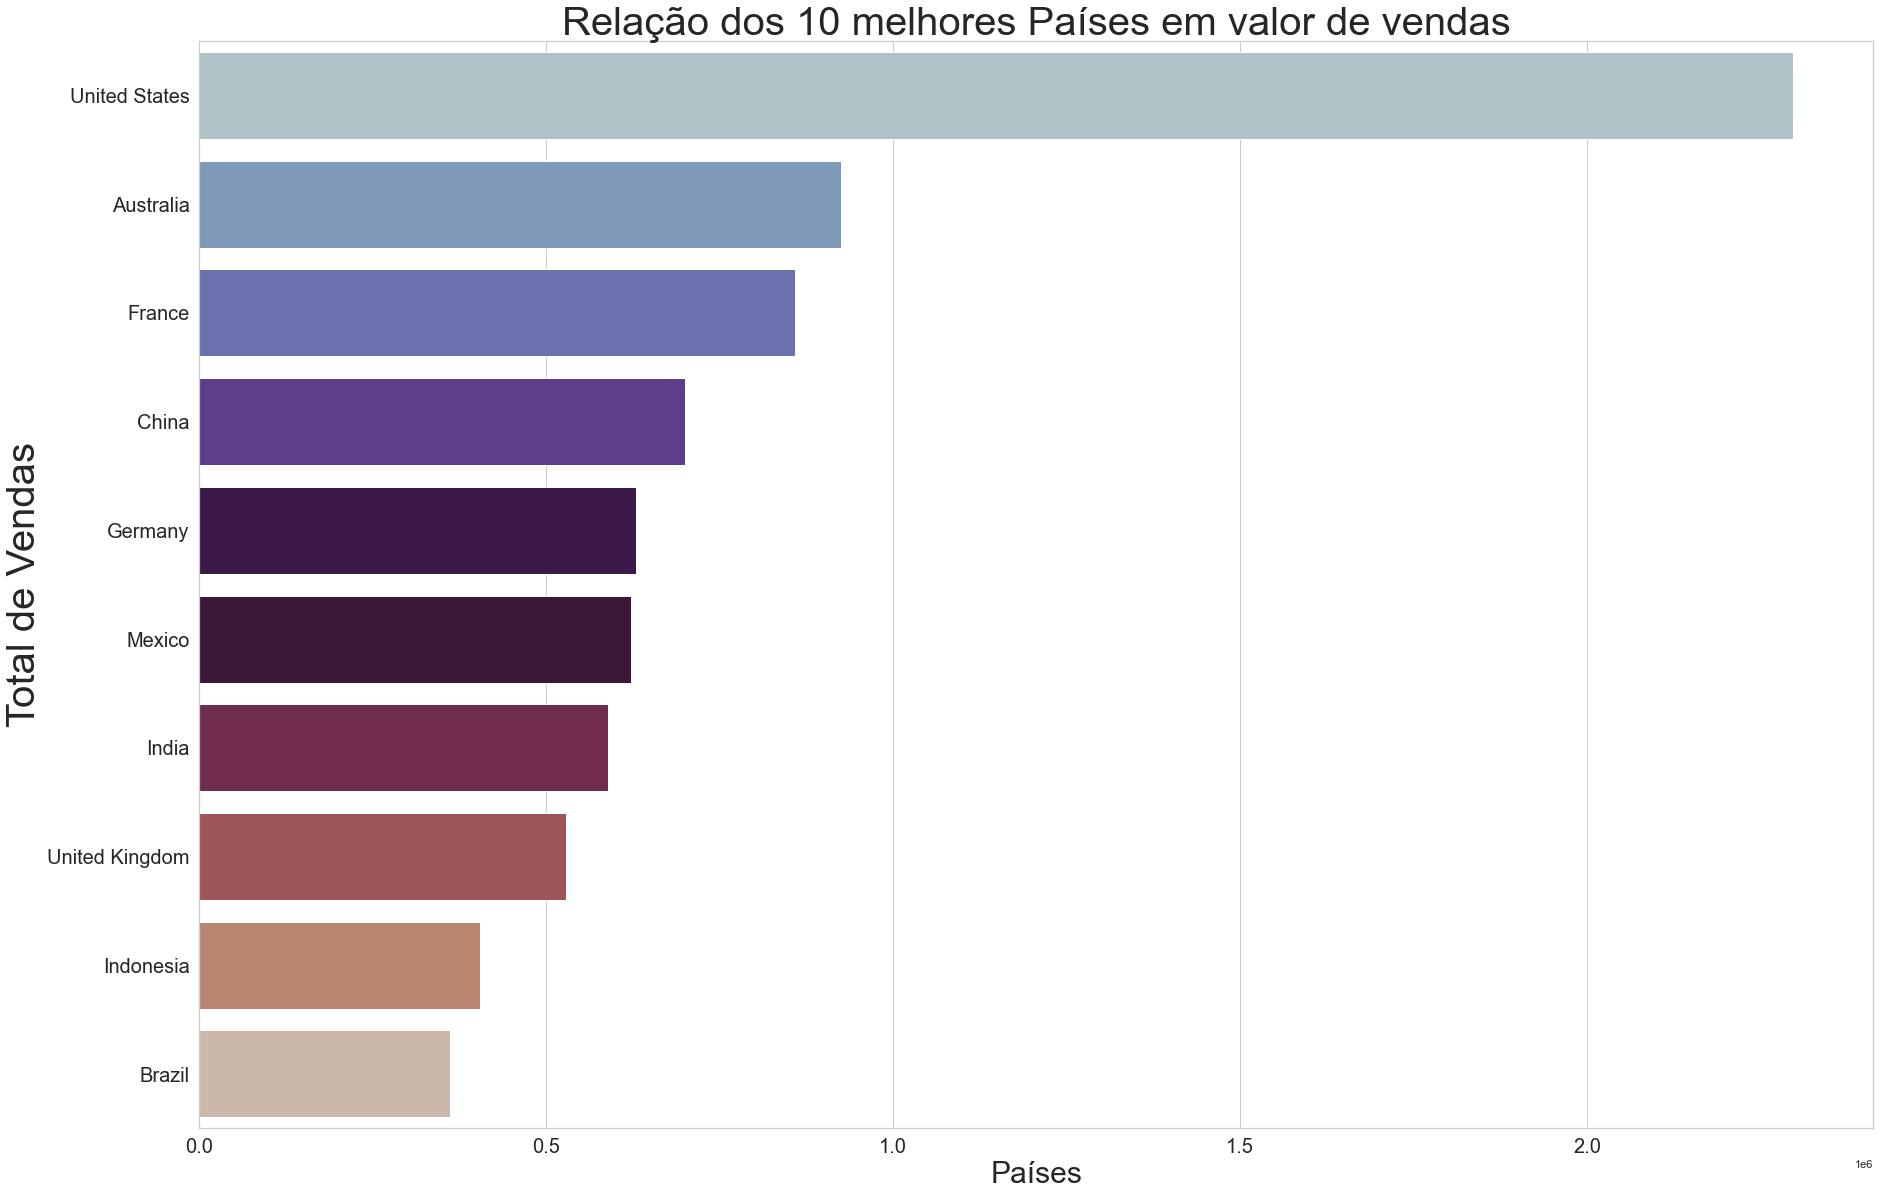

In [96]:
sns.set_theme(style="whitegrid")
ax = plt.subplots(figsize=dims)

b = sns.barplot(y="country", x="sales", data=dff.sort_values(by=["sales"], ascending=False).head(10), palette=("twilight"))
b.axes.set_title("Relação dos 10 melhores Países em valor de vendas",fontsize=40)
b.set_xlabel("Países",fontsize=30)
b.set_ylabel("Total de Vendas",fontsize=40)
b.tick_params(labelsize=20)


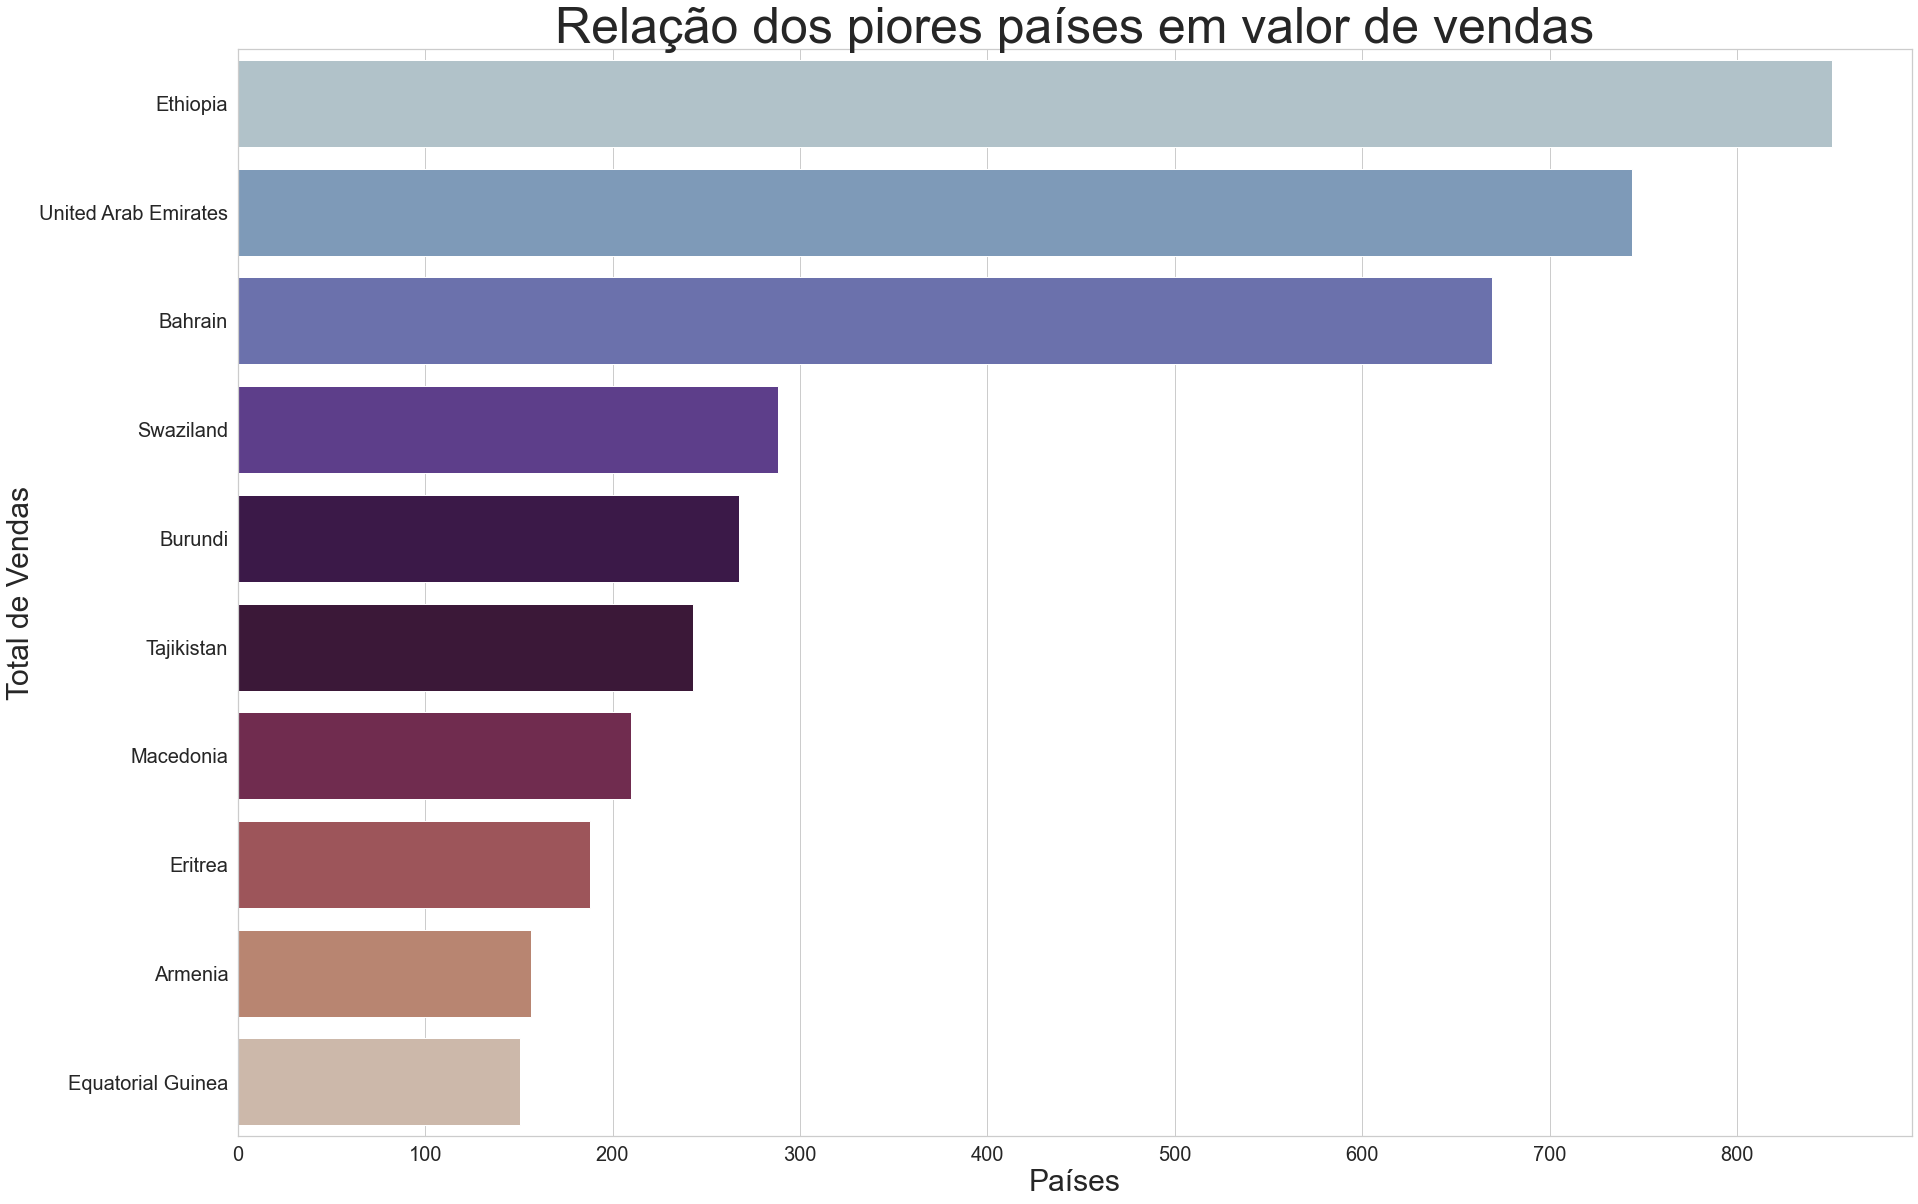

In [97]:
ax = plt.subplots(figsize=dims)
b = sns.barplot(x="sales", y="country", data=dff.sort_values(by=["sales"], ascending=False).tail(10), palette=("twilight"))
b.axes.set_title("Relação dos piores países em valor de vendas",fontsize=50)
b.set_xlabel("Países",fontsize=30)
b.set_ylabel("Total de Vendas",fontsize=30)
b.tick_params(labelsize=20)

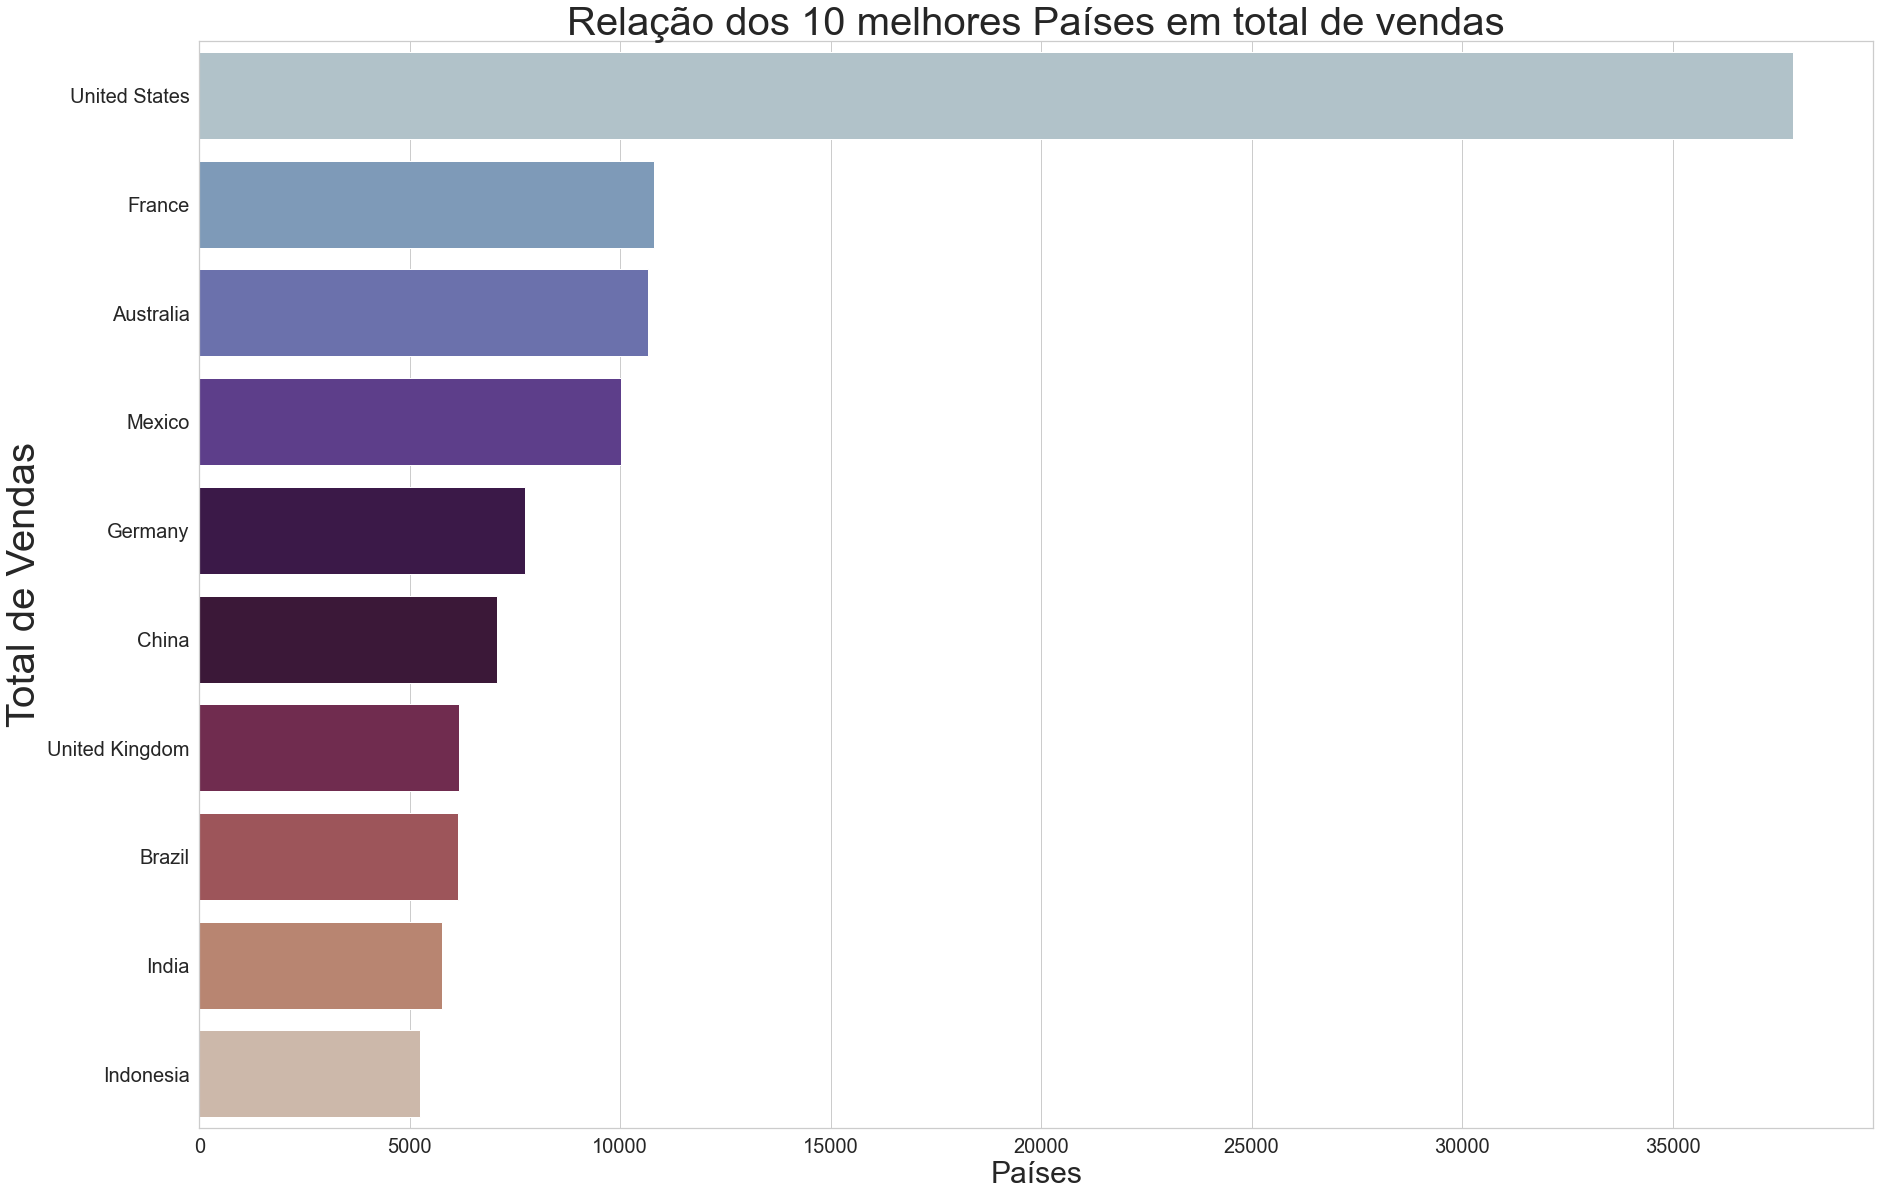

In [98]:
res=pd.concat([dff,dff_q])
sns.set_theme(style="whitegrid")
ax = plt.subplots(figsize=dims)

b = sns.barplot(y="country", x="quantity", data=dff_q.sort_values(by=["quantity"], ascending=False).head(10), palette=("twilight"))
b.axes.set_title("Relação dos 10 melhores Países em total de vendas",fontsize=40)
b.set_xlabel("Países",fontsize=30)
b.set_ylabel("Total de Vendas",fontsize=40)
b.tick_params(labelsize=20)

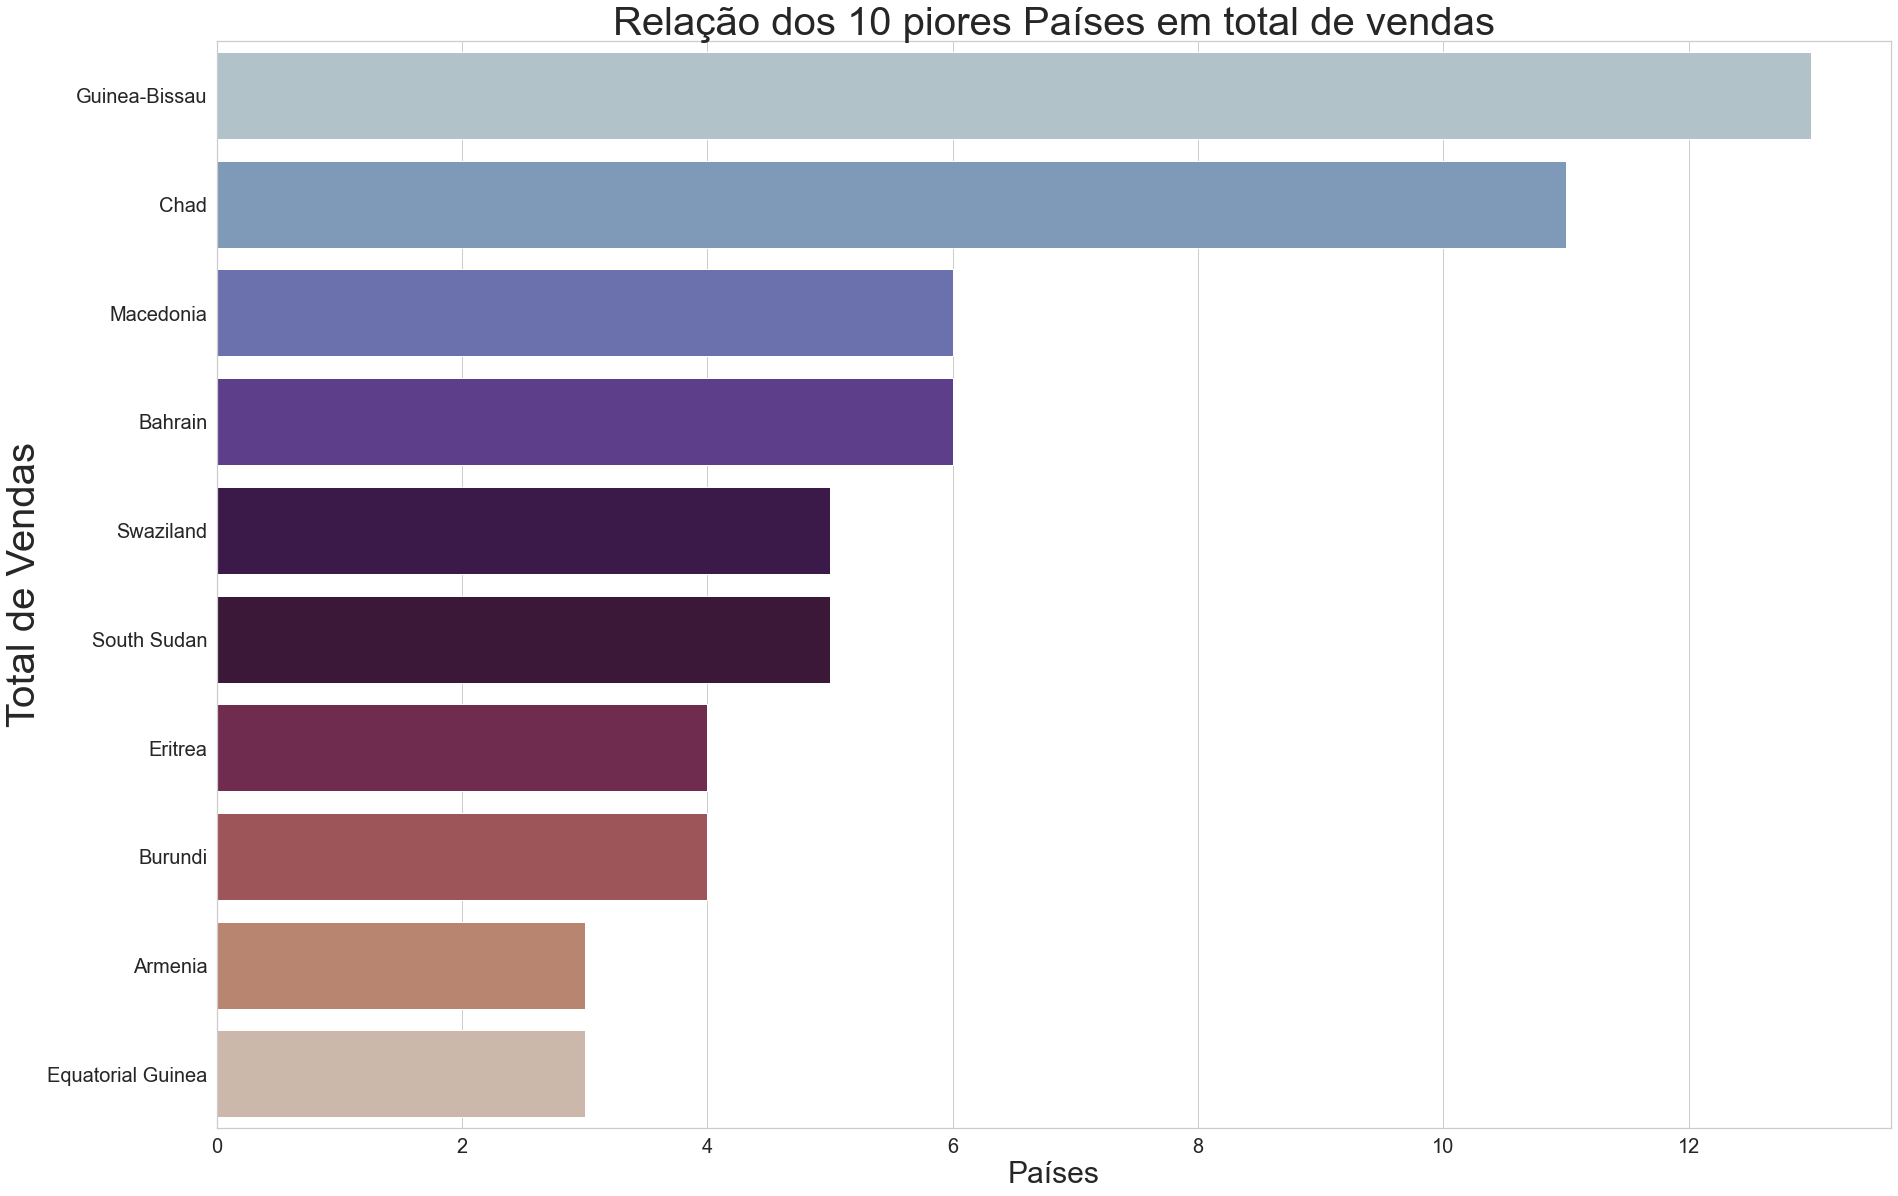

In [99]:
res=pd.concat([dff,dff_q])
sns.set_theme(style="whitegrid")
ax = plt.subplots(figsize=dims)

b = sns.barplot(y="country", x="quantity", data=dff_q.sort_values(by=["quantity"], ascending=False).tail(10), palette=("twilight"))
b.axes.set_title("Relação dos 10 piores Países em total de vendas",fontsize=40)
b.set_xlabel("Países",fontsize=30)
b.set_ylabel("Total de Vendas",fontsize=40)
b.tick_params(labelsize=20)

### Expectativas para o próximo mês

In [100]:
df["category"].value_counts()

Office Supplies    31273
Technology         10141
Furniture           9876
Name: category, dtype: int64

Primeiramente trabalharemos com o Dataset inteiro, sem distinção entre produtos ou categorias

In [101]:
matplotlib.rcParams['figure.figsize'] = [16, 4]

In [102]:
df.dtypes

row_id                     int64
order_id                  object
order_date        datetime64[ns]
ship_date                 object
ship_mode                 object
customer_id               object
customer_name             object
segment                   object
city                      object
state                     object
country                   object
market                    object
region                    object
product_id                object
category                  object
sub_category              object
product_name              object
sales                    float64
quantity                   int64
discount                 float64
profit                   float64
shipping_cost            float64
order_priority             int64
dtype: object

In [103]:
#Relação por Quantidade
columns = df[["order_date","quantity"]]
data_ts = columns.copy()
data_ts['order_date'] = pd.to_datetime(data_ts.order_date)
data_ts = data_ts.groupby(["order_date"]).quantity.sum().reset_index()

In [104]:
#Relação por Valor de Vendas
columns = df[["order_date","sales"]]
data_vl = columns.copy()
data_vl['order_date'] = pd.to_datetime(data_vl.order_date)
data_vl = data_vl.groupby(["order_date"]).sales.sum().reset_index()

In [105]:
data_ts = data_ts.set_index(['order_date'])
data_vl = data_vl.set_index(['order_date'])

In [106]:
data_ts

,quantity
order_date,
2011-01-01,19
2011-01-02,54
2011-01-03,177
2011-01-04,86
2011-01-06,154
...,...
2014-12-27,188
2014-12-28,51
2014-12-29,408


In [107]:
s_ = data_ts.squeeze()
s__ = data_vl.squeeze()

idx = pd.date_range('2011-01-01', '2014-12-31')

s_ = s_.reindex(idx, fill_value=0)
s__ = s__.reindex(idx, fill_value=0)

In [108]:
data_ts = s_.to_frame()
data_vl = s__.to_frame()

In [109]:
data_ts.index.name = "order_date"
data_vl.index.name = "order_date"

In [110]:
data_ts

,quantity
order_date,
2011-01-01,19
2011-01-02,54
2011-01-03,177
2011-01-04,86
2011-01-05,0
...,...
2014-12-27,188
2014-12-28,51
2014-12-29,408


In [111]:
'''correlacao = data_ts['quantity'].corr(data_vl['sales'])
print("Correlação de vendas entre as duas séries: ", np.round(correlacao*100), "%" ) 
plt.scatter(data_ts['quantity'], data_vl['sales'])
plt.show()'''

'correlacao = data_ts[\'quantity\'].corr(data_vl[\'sales\'])\nprint("Correlação de vendas entre as duas séries: ", np.round(correlacao*100), "%" ) \nplt.scatter(data_ts[\'quantity\'], data_vl[\'sales\'])\nplt.show()'

In [112]:
data_vl

,sales
order_date,
2011-01-01,808.56300
2011-01-02,2455.67000
2011-01-03,12565.76630
2011-01-04,2582.80100
2011-01-05,0.00000
...,...
2014-12-27,13421.26376
2014-12-28,1647.17400
2014-12-29,25109.28878


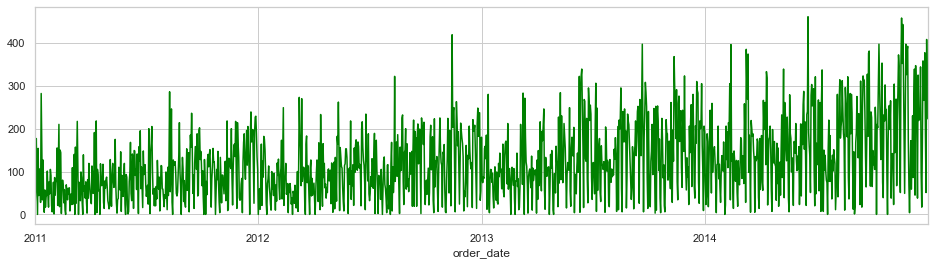

In [113]:
data_ts['quantity'].plot(grid = True, color="green")

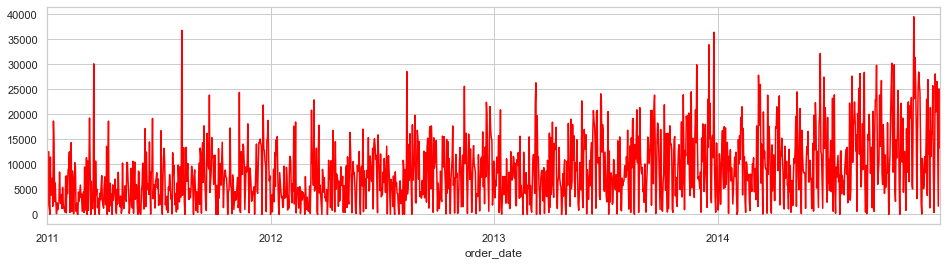

In [114]:
data_vl['sales'].plot(grid = True, color="red")

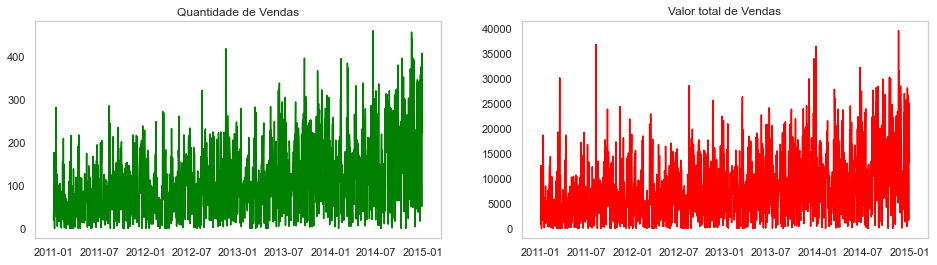

In [115]:
fig, ax = plt.subplots(1,2)
ax[0].plot(data_ts.index, data_ts.quantity, color='green')
ax[0].grid()
ax[0].set_title('Quantidade de Vendas')

ax[1].plot(data_vl.index, data_vl.sales, color='red')
ax[1].grid()
ax[1].set_title('Valor total de Vendas')

plt.show()

In [116]:
from statsmodels.tsa.stattools import adfuller
fuller_qt = adfuller(data_ts.quantity)
fuller_ = adfuller(data_vl.sales)
print('p-valor do Teste aumentado de Dickey-Fuller para série 1: {0:.2f}'.format(np.round(fuller_qt[1],2))) 
print('p-valor do Teste aumentado de Dickey-Fuller para série 2: {0:.2f}'.format(np.round(fuller_[1],2)))

p-valor do Teste aumentado de Dickey-Fuller para série 1: 0.00
p-valor do Teste aumentado de Dickey-Fuller para série 2: 0.00


In [117]:
data_vl.sales

order_date
2011-01-01      808.56300
2011-01-02     2455.67000
2011-01-03    12565.76630
2011-01-04     2582.80100
2011-01-05        0.00000
                 ...     
2014-12-27    13421.26376
2014-12-28     1647.17400
2014-12-29    25109.28878
2014-12-30    16831.61480
2014-12-31    13257.95430
Freq: D, Name: sales, Length: 1461, dtype: float64

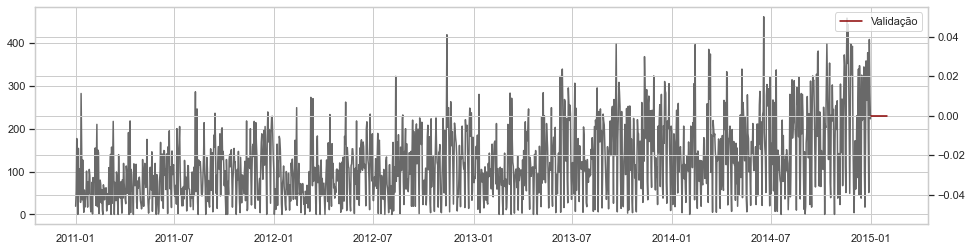

In [118]:
#test_size = 0.75
#train = data_ts.reset_index().loc[0:np.round(data_ts.shape[0] * test_size),:]
#test = data_ts.reset_index().loc[np.round(data_ts.shape[0] * test_size):,:]

train = data_ts.reset_index()
test = pd.Series(pd.date_range("2015-01-01", "2015-01-31"))
test = test.to_frame(name="order_date")
test.set_index(['order_date'])
test['quantity'] = 0


fig, ax = plt.subplots()
ax.plot(train.order_date, train.quantity, color='dimgray', label='Treino')
ax2 = ax.twinx()

ax2.plot(test.order_date, test.quantity, color='darkred',label='Validação')
plt.legend()
plt.show()

In [119]:
test

,order_date,quantity
0,2015-01-01,0
1,2015-01-02,0
2,2015-01-03,0
3,2015-01-04,0
4,2015-01-05,0
5,2015-01-06,0
6,2015-01-07,0
7,2015-01-08,0
8,2015-01-09,0
9,2015-01-10,0


In [120]:
from statsmodels.tsa.arima_model import ARMA

In [121]:
train.head()
train.index = train['order_date']

In [122]:
data_ts.tail()

,quantity
order_date,
2014-12-27,188
2014-12-28,51
2014-12-29,408
2014-12-30,284
2014-12-31,223


In [123]:
model = ARMA(train.quantity, order=(6,1))

trained_model = model.fit()

print(trained_model.summary())
predict_ = trained_model.predict(start = test.order_date.min(), end = test.order_date.max())

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                              ARMA Model Results                              
Dep. Variable:               quantity   No. Observations:                 1461
Model:                     ARMA(6, 1)   Log Likelihood               -8393.760
Method:                       css-mle   S.D. of innovations             75.642
Date:                Wed, 08 Sep 2021   AIC                          16805.520
Time:                        16:17:01   BIC                          16853.102
Sample:                    01-01-2011   HQIC                         16823.270
                         - 12-31-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            122.9575      7.779     15.807      0.000     107.711     138.204
ar.L1.quantity     0.8246      0.066     12.422      0.000       0.695       0.955
ar.L2.quantity    -0.1851      0.038

In [124]:
#Dados previstos para o mês de Janeiro 20115
predict_.to_frame()

,0
2015-01-01,265.872040
2015-01-02,229.547193
2015-01-03,171.043184
2015-01-04,210.918774
2015-01-05,219.360391
2015-01-06,201.207977
2015-01-07,207.148588
2015-01-08,205.190987
2015-01-09,187.302272
2015-01-10,183.675959


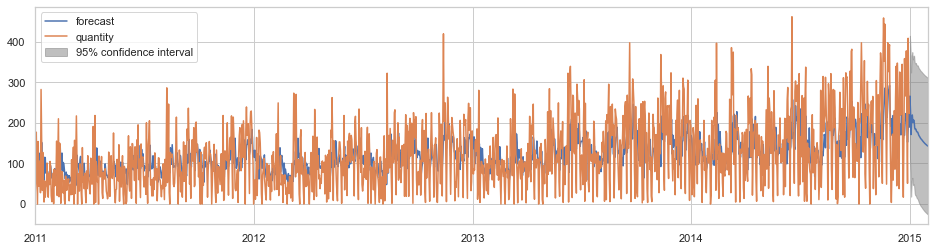

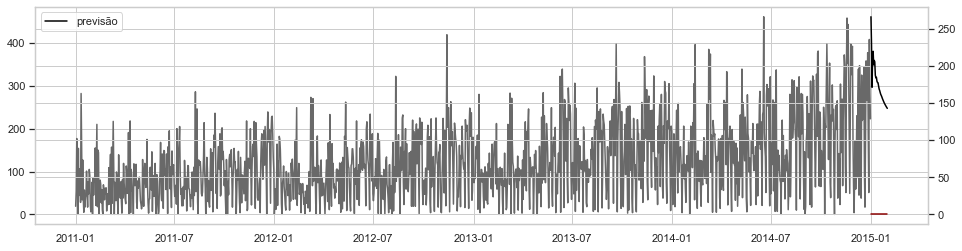

In [125]:
trained_model.plot_predict(start = train.order_date.min(), end = test.order_date.max());

fig, ax = plt.subplots()
ax.plot(train.order_date, train.quantity, color='dimgray')
ax2 = ax.twinx()
ax2.plot(test.order_date, test.quantity, color='darkred')
ax2.plot(test.order_date, predict_, color='black',label='previsão')

plt.legend()
plt.show()

p-valor do Teste aumentado de Dickey-Fuller para o residuo do modelo: 0.00


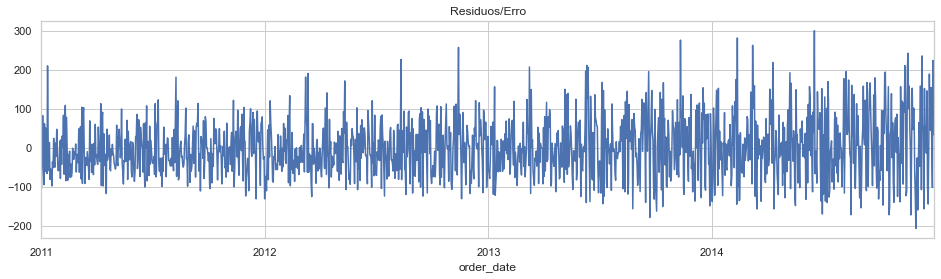

In [126]:
trained_model.resid.plot(grid = True, title  = 'Residuos/Erro')
adfuller_residuo = adfuller(trained_model.resid)
print('p-valor do Teste aumentado de Dickey-Fuller para o residuo do modelo: {0:.2f}'.format(np.round(adfuller_residuo[1],2)))